<a href="https://colab.research.google.com/github/IsaacFigNewton/PMF-Classifier/blob/main/KNN_Estimation_of_Feature_Probability_Distributions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#TODO

1.  Integrate inverse-distance kernel weighting


2.  Add Feature-Dependent Weighting:

  a. Develop a weighting scheme based on the percentage of variability in the class attributable to each feature.

  b. Adjust the influence of each feature in the final decision-making process according to its calculated weight.

# Import Libraries and Config

In [1]:
import numpy as np
from collections import defaultdict
import pandas as pd
import json
import seaborn as sns
from itertools import permutations, product
import matplotlib.pyplot as plt

import sklearn as sk
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y,\
                                      check_is_fitted,\
                                      check_array
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer,\
                                      KBinsDiscretizer,\
                                      OneHotEncoder,\
                                      StandardScaler
from sklearn.neighbors import KernelDensity,\
                                      KNeighborsRegressor,\
                                      KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB,\
                                      MultinomialNB
from sklearn.svm import SVC as SVM
from sklearn.neural_network import MLPClassifier as MLP
from sklearn.ensemble import RandomForestClassifier


from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_score,\
                                      recall_score,\
                                      accuracy_score,\
                                      f1_score,\
                                      make_scorer
from sklearn.model_selection import KFold,\
                                      GridSearchCV,\
                                      cross_val_score,\
                                      cross_validate

In [2]:
# Prepare for k-fold cross-validation
default_n_neighbors = 1
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
colormap = {
    0: 'red',
    1: 'green'
}
class_map = dict()

# Lists to store evaluation metrics
precisions, recalls, accuracies, f1_scores = [], [], [], []

# Important Functions

## Probability Mass Function Estimator Class

In [3]:
class PMFRegressor(ClassifierMixin, BaseEstimator):

    def __init__(self, max_bins=None, alpha=1e-9, n_neighbors=1):
        # Max bins for discretization, to limit memory usage
        self.max_bins = max_bins
        # minimum weighted probability (0 implies that the feature of datapoints belonging to a class never takes on a given value)
        self.alpha = alpha
        #Number of neighbors to use in KNN estimation
        self.n_neighbors = n_neighbors

        #  DO NOT APPEND UNDERSCORES TO X AND y
        self.X = None
        self.y = None
        self.classes_ = None

        self.prior_class_probabilities = None
        self.pmf_dict = None
        self.knn_model_store = None


    def fit(self, X, y):
        # Check that X and y have correct shape
        X, y = check_X_y(X, y)

        self.X = X
        self.y = y
        self.classes_ = np.unique(y)

        # Estimate the probability mass function
        self.prior_class_probabilities = {class_value: self.get_prior_probability(class_value) for class_value in self.classes_}
        # create a multilevel dict to represent the weighted probabilities of every unique value of every feature for every class
        self.pmf_dict = {class_value: {feature: {} for feature in range(self.X.shape[1])} for class_value in self.classes_}
        # create a dict to store PMFs for each feature and unique value
        self.knn_model_store = {class_value: {feature: defaultdict() for feature in range(self.X.shape[1])} for class_value in self.classes_}


        # Add the weighted probabilities of the unique value to the feature distribution set
        for class_value in self.classes_:
            # Calculating and storing PMFs
            for feature in range(self.X.shape[1]):
                # Get unique values for the current feature
                # default; discretize down to scale of datapoints
                unique_values = np.unique(self.X[:, feature])

                # alternate; discretize down to datapoints or max_bins
                if self.max_bins is not None and len(unique_values) > self.max_bins:
                    discretizer = KBinsDiscretizer(n_bins=self.max_bins, encode='ordinal', strategy='quantile')
                    unique_values = discretizer.fit_transform(unique_values.reshape(-1, 1)).flatten()


                # Calculate the weighted probability for each unique value
                for unique_value in unique_values:

                        # Calculate the probability distribution for the current feature and unique value
                        pmf_val, p_unique = self.calc_pmf_at_value(class_value, feature, unique_value)

                        self.pmf_dict[class_value][feature][unique_value] = pmf_val

                        # Create a KNN for the current feature
                        pmf = self.create_pmf_using_knn(class_value, feature)

                        # Store the KNN for the current feature and class
                        self.knn_model_store[class_value][feature] = pmf

        # Return the classifier
        return self


    def predict(self, X):
        # Check if fit has been called
        check_is_fitted(self)
        # Input validation
        X = check_array(X)
        y = np.empty(X.shape[0], dtype=self.classes_.dtype)

        for i in range(X.shape[0]):
            datapoint = {j: X[i, j] for j in range(X.shape[1])}
            class_probabilities = self.calculate_class_probabilities(datapoint)

            predicted_class = max(class_probabilities, key=class_probabilities.get)
            y[i] = predicted_class

        return y



    # Main functions
    #*******************************************************************************************************************************************


    # Function to get prior probability of the class
    def get_prior_probability(self, class_value):
        return np.sum(self.y == class_value) / len(self.X)


    # Function to calculate probability distribution
    def calc_pmf_at_value(self, class_value, feature, unique_value):
        # Calculate P(unique_val | feature)
        mask = self.X[:, feature] == unique_value
        p_unique = np.sum(mask) / len(self.X)

        # Filter the dataset for the current class and feature value
        class_mask = self.y == class_value
        class_data_mask = mask & class_mask

        # Calculate P(unique_val | feature /\ class)
        p_unique_given_class = np.sum(class_data_mask) / np.sum(class_mask)

        # Avoid division by zero
        if p_unique > 0:
            # Calculate P(unique_val | feature /\ class)/P(unique_val | feature)
            pmf_value = p_unique_given_class / p_unique
        else:
            # No data for this unique value
            pmf_value = self.alpha

        return pmf_value, p_unique


    # Function to get values and their associated probabilities for the current feature and class
    def get_feature_class_vals_and_probs(self, class_value, feature):
        pmf_class_feature = self.pmf_dict[class_value][feature]

        # print(pmf_class_feature)

        # Get the values for the current feature and class
        values = np.array(\
                                list(\
                                    pmf_class_feature.keys())).reshape(-1, 1)
        # Get the weighted probabilities for the current feature and class
        probabilities = np.array(\
                                 list(\
                                      pmf_class_feature.values()))

        return values, probabilities


    # Function to create a KNN for prob_distribution in the current feature and class
    def create_pmf_using_knn(self, class_value, feature):
        values, probabilities = self.get_feature_class_vals_and_probs(class_value, feature)

        # Create a kernel density estimator using Gaussian kernel
        knn = KNeighborsRegressor(n_neighbors=self.n_neighbors).fit(values, probabilities)

        return knn


    def get_standardized_feature_contributions(self):
      # Get the sum of squares of all residuals

      # Get the residuals of all the points on the discretized PMF
      squared_residuals = self.pmf_df.sub(self.y, axis=0) ** 2

      # Get the sum of squares (SS) for each feature
      sum_of_squares = squared_residuals.sum()

      return np.divide(squared_residuals, sum_of_squares)


    # get the weights for each neighbor of a test datapoint in a given feature
    def get_knn_weighted_avg(self,
                            class_value,
                            feature, value,
                            neighbor_indices,
                            neighbor_distances):
        values, probabilities = self.get_feature_class_vals_and_probs(class_value, feature)
        neighbor_values = values[neighbor_indices]


        # handle edge cases where something went horribly wrong
        #   and where n_neighbors = 1 and thus the only weight will be 0
        if len(neighbor_values) == 0:
            return 0
        elif len(neighbor_values) == 1:
            return probabilities[neighbor_indices[0]]

        # get modified inverse distance weights
        standardized_distances = np.divide(neighbor_distances,
                                     np.sum(neighbor_distances))
        distance_weights = np.divide(1 - standardized_distances,
                                     np.sum(standardized_distances))

        weighted_avg = np.average(probabilities[neighbor_indices],
                                  weights=distance_weights)

        # print(neighbor_distances)
        # print(standardized_distances)
        # print(distance_weights)

        return weighted_avg


    # Function to calculate P(class | feature1_value /\ feature2_value /\ …)
    def calculate_class_probabilities(self, feature_values):
        class_probabilities = {class_value: 1 for class_value in self.prior_class_probabilities.keys()}

        for class_value in self.prior_class_probabilities.keys():
            likelihood = 1
            for feature, value in feature_values.items():
                # feature_likelihood = self.knn_model_store[class_value][feature].predict(np.array([[value]]))
                # # Accumulate features' weighted probabilities
                # likelihood *= feature_likelihood

                datapoint = np.array([[value]])
                model = self.knn_model_store[class_value][feature]

                # Get the custom weighted KNN estimate for the current datapoint, feature, and class
                # Get the neighbors of the current datapoint and their indices in
                distances, indices = model.kneighbors(X=datapoint, n_neighbors=self.n_neighbors)

                # datapoint_class_likelihood = self.get_knn_weighted_avg(class_value,
                #                                                  feature,
                #                                                  datapoint,
                #                                                  indices,
                #                                                  distances)
                # print()

                datapoint_class_likelihood = model.predict(datapoint)
                # print(datapoint_class_likelihood)

                # Accumulate features' weighted probabilities
                #   and multiply by the standardized feature contributions to the data's output
                likelihood *= datapoint_class_likelihood# * self.standardized_feature_contributions[feature]

            # Get final class probability
            class_probability = likelihood * self.prior_class_probabilities[class_value]
            class_probabilities[class_value] = class_probability

        return class_probabilities



    # Helper functions
    #*******************************************************************************************************************************************

    # Map the features' weighted probability distributions to lists of features' values and their weighted probabilities
    def pmf_dict_to_dict(self):
        return {
            class_value: {
                feature: (list(self.pmf_dict[class_value][feature].keys()),
                          list(self.pmf_dict[class_value][feature].values()))
                for feature in range(self.X.shape[1])
            } for class_value in self.classes_
        }


    def print_weighted_prob_dist(self):
        print("Feature Distribution:")
        print(self.pmf_dict_to_dict())

## Utility

In [4]:
# Custom transformer to convert sparse matrix to dense
def to_dense(X):
    return np.array(X.todense()) if hasattr(X, 'todense') else X

dense_transformer = FunctionTransformer(to_dense)

In [5]:
def print_tree(tree, indent=0):
    # Iterate over the keys (features) in the tree
    for key, value in tree.items():
        print(' ' * indent + str(key))
        # If the value is a dictionary, recursively print the subtree
        if isinstance(value, dict):
            print_tree(value, indent + 4)
        else:
            print(' ' * (indent + 4) + str(value))

In [6]:
def cv_results_to_dict(pipeline, X, y):
    model_name = pipeline.steps[-1][0]

    # Perform cross-validation
    cv_results = cross_validate(pipeline,
                                X,
                                y,
                                cv=kf,
                                scoring=scoring,
                                return_train_score=False)

    # Calculate average scores and standard deviations
    avg_scores[model_name] = {
            "precision": cv_results['test_precision'].mean(),
            "recall": cv_results['test_recall'].mean(),
            "accuracy": cv_results['test_accuracy'].mean(),
            "f1": cv_results['test_f1'].mean(),
            "std_precision": cv_results['test_precision'].std(),
            "std_recall": cv_results['test_recall'].std(),
            "std_accuracy": cv_results['test_accuracy'].std(),
            "std_f1": cv_results['test_f1'].std(),
    }

    # Print average scores
    print("\nAverage Scores:")
    print(f"Precision: {avg_scores[model_name]['precision']:.4f} (+/- {avg_scores[model_name]['std_precision']:.4f})")
    print(f"Recall: {avg_scores[model_name]['recall']:.4f} (+/- {avg_scores[model_name]['std_recall']:.4f})")
    print(f"Accuracy: {avg_scores[model_name]['accuracy']:.4f} (+/- {avg_scores[model_name]['std_accuracy']:.4f})")
    print(f"F1 Score: {avg_scores[model_name]['f1']:.4f} (+/- {avg_scores[model_name]['std_f1']:.4f})")

    # If you want to see individual fold scores:
    for fold, (precision, recall, accuracy, f1) in enumerate(zip(
        cv_results['test_precision'],
        cv_results['test_recall'],
        cv_results['test_accuracy'],
        cv_results['test_f1']
    ), 1):
        print(f"\nFold {fold}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"F1 Score: {f1:.4f}")

# Import and Clean Dataset

In [7]:
# Load the dataset
# Titanic
dataset = pd.read_csv("https://raw.githubusercontent.com/dlsun/pods/master/data/titanic.csv")
dataset.drop(columns=["name", "ticketno"], inplace=True)
dataset.dropna(inplace=True)
dataset.reset_index(drop=True, inplace=True)

# take a sample for faster testing
dataset = dataset.loc[:200]
print(len(dataset))

# Identify categorical, continuous, and binary columns
quantitative_vars = ["age", "fare"]
categorical_vars = ["gender", "embarked", "class", "country"]
X = quantitative_vars + categorical_vars

y = ['survived']
class_map = {key: i for i, key in enumerate(dataset[y[0]].unique())}

dataset.head()

201


,gender,age,class,embarked,country,fare,survived
0,male,42.0,3rd,S,United States,7.11,0
1,male,13.0,3rd,S,United States,20.05,0
2,male,16.0,3rd,S,United States,20.05,0
3,female,39.0,3rd,S,England,20.05,1
4,female,16.0,3rd,S,Norway,7.13,1


In [8]:
preprocessor = ColumnTransformer(
    transformers=[
        ('categorical', OneHotEncoder(handle_unknown='ignore'), categorical_vars),
        ('continuous', StandardScaler(), quantitative_vars)
    ],
    remainder='passthrough'
)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('to_dense', dense_transformer)
])

pipeline.fit(dataset[X])
transformed_feature_names = pipeline[:-1].get_feature_names_out()

# transform the dataset
transformed_dataset = pd.DataFrame(pipeline.transform(dataset[X]),
                                   columns=transformed_feature_names)
# add the y values back in, after resetting their indices
transformed_dataset[y[0]] = dataset[y[0]].reset_index(drop=True)
transformed_dataset.head()

,categorical__gender_female,categorical__gender_male,categorical__embarked_C,categorical__embarked_Q,categorical__embarked_S,categorical__class_1st,categorical__class_2nd,categorical__class_3rd,categorical__country_Argentina,categorical__country_Bosnia,...,categorical__country_Siam,categorical__country_South Africa,categorical__country_Sweden,categorical__country_Switzerland,categorical__country_United States,categorical__country_Uruguay,categorical__country_Wales,continuous__age,continuous__fare,survived
0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.981797,-0.463258,0
1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-1.092717,-0.273960,0
2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.878113,-0.273960,0
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.767192,-0.273960,1
4,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.878113,-0.462966,1


In [9]:
transformed_dataset[transformed_dataset.isnull().any(axis=1)]

,categorical__gender_female,categorical__gender_male,categorical__embarked_C,categorical__embarked_Q,categorical__embarked_S,categorical__class_1st,categorical__class_2nd,categorical__class_3rd,categorical__country_Argentina,categorical__country_Bosnia,...,categorical__country_Siam,categorical__country_South Africa,categorical__country_Sweden,categorical__country_Switzerland,categorical__country_United States,categorical__country_Uruguay,categorical__country_Wales,continuous__age,continuous__fare,survived


In [10]:
len(transformed_dataset)

201

In [11]:
transformed_dataset.dropna(inplace=True)
len(transformed_dataset)

201

# Data Exploration

In [12]:
# # Parse the loose JSON representation into a dataframe

# # Initialize an empty list to store the rows
# rows = []

# # Iterate through the dictionary to extract the data
# for class_value, features in pmf_dict_x_y.items():
#     for feature, (x_values, y_values) in features.items():
#         # Create a DataFrame for the current feature
#         df_feature = pd.DataFrame({
#             'Class': class_value,
#             'Feature': feature,
#             'Feature Value': x_values,
#             'Weighted Probability': y_values
#         })
#         # Append the DataFrame to the rows list
#         rows.append(df_feature)

# # Concatenate all rows into a single DataFrame
# df = pd.concat(rows, ignore_index=True)

# df

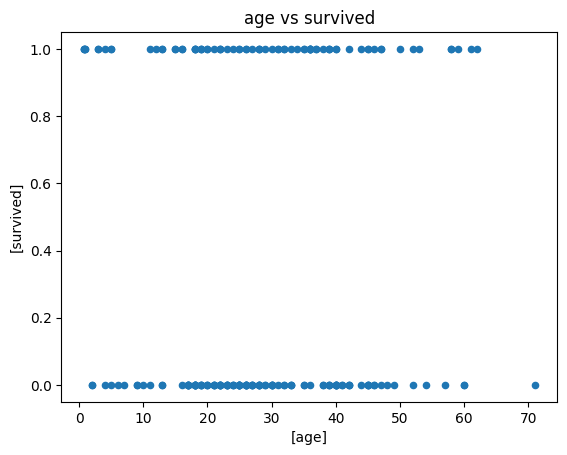

In [13]:
dataset.plot.scatter(x=[quantitative_vars[0]], y=y)
plt.title(f"{quantitative_vars[0]} vs {y[0]}")
plt.show()

# Cross Validation Against other Models

In [14]:
transformed_dataset.head()

,categorical__gender_female,categorical__gender_male,categorical__embarked_C,categorical__embarked_Q,categorical__embarked_S,categorical__class_1st,categorical__class_2nd,categorical__class_3rd,categorical__country_Argentina,categorical__country_Bosnia,...,categorical__country_Siam,categorical__country_South Africa,categorical__country_Sweden,categorical__country_Switzerland,categorical__country_United States,categorical__country_Uruguay,categorical__country_Wales,continuous__age,continuous__fare,survived
0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.981797,-0.463258,0
1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-1.092717,-0.273960,0
2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.878113,-0.273960,0
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.767192,-0.273960,1
4,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.878113,-0.462966,1


In [15]:
# Define the scoring metrics
scoring = {
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'accuracy': make_scorer(accuracy_score),
    'f1': make_scorer(f1_score)
}

avg_scores = dict()

## Sklearn Classifiers


Average Scores:
Precision: 0.6996 (+/- 0.0335)
Recall: 0.6384 (+/- 0.0655)
Accuracy: 0.7462 (+/- 0.0432)
F1 Score: 0.6661 (+/- 0.0437)

Fold 1
Precision: 0.6667
Recall: 0.6667
Accuracy: 0.7561
F1 Score: 0.6667

Fold 2
Precision: 0.7273
Recall: 0.5714
Accuracy: 0.7750
F1 Score: 0.6400

Fold 3
Precision: 0.6875
Recall: 0.5789
Accuracy: 0.6750
F1 Score: 0.6286

Fold 4
Precision: 0.7500
Recall: 0.7500
Accuracy: 0.8000
F1 Score: 0.7500

Fold 5
Precision: 0.6667
Recall: 0.6250
Accuracy: 0.7250
F1 Score: 0.6452


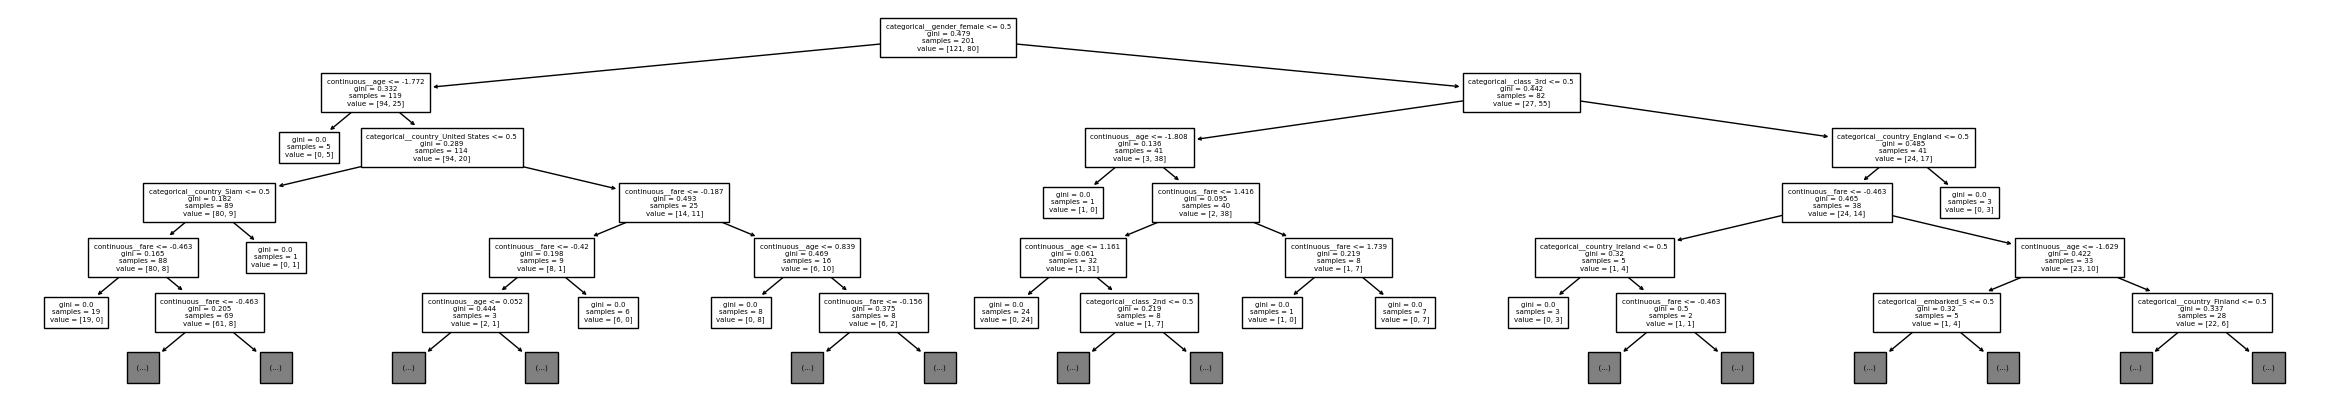

In [16]:
# Create a pipeline with preprocessor and DecisionTreeClassifier
pipeline = Pipeline([
    ('decision tree classifier', DecisionTreeClassifier())
])

cv_results_to_dict(pipeline, transformed_dataset[transformed_feature_names], transformed_dataset[y[0]])

# Fit the pipeline to the data
pipeline.fit(transformed_dataset[transformed_feature_names], transformed_dataset[y[0]])

# Create a figure and axis with a wider x-axis
fig, ax = plt.subplots(figsize=(30, 5))

# Plot the decision tree
sk.tree.plot_tree(pipeline.named_steps['decision tree classifier'],
                  max_depth=5,
                  feature_names=transformed_feature_names,
                  fontsize=5,
                  ax=ax)

plt.show()

In [17]:
# Create a pipeline with preprocessor and KNeighborsClassifier
pipeline = Pipeline([
    ('knn classifier', KNeighborsClassifier(n_neighbors=default_n_neighbors))
])

cv_results_to_dict(pipeline, transformed_dataset[transformed_feature_names], transformed_dataset[y[0]])


Average Scores:
Precision: 0.6499 (+/- 0.0520)
Recall: 0.6208 (+/- 0.1074)
Accuracy: 0.7112 (+/- 0.0671)
F1 Score: 0.6305 (+/- 0.0643)

Fold 1
Precision: 0.6316
Recall: 0.8000
Accuracy: 0.7561
F1 Score: 0.7059

Fold 2
Precision: 0.7500
Recall: 0.6429
Accuracy: 0.8000
F1 Score: 0.6923

Fold 3
Precision: 0.6000
Recall: 0.4737
Accuracy: 0.6000
F1 Score: 0.5294

Fold 4
Precision: 0.6429
Recall: 0.5625
Accuracy: 0.7000
F1 Score: 0.6000

Fold 5
Precision: 0.6250
Recall: 0.6250
Accuracy: 0.7000
F1 Score: 0.6250


In [18]:
# Create a pipeline with preprocessor and GaussianNB classifier
pipeline = Pipeline([
    ('gaussian naive bayes classifier', GaussianNB())
])


cv_results_to_dict(pipeline, transformed_dataset[transformed_feature_names], transformed_dataset[y[0]])


Average Scores:
Precision: 0.4388 (+/- 0.0371)
Recall: 0.9664 (+/- 0.0433)
Accuracy: 0.4924 (+/- 0.0415)
F1 Score: 0.6015 (+/- 0.0287)

Fold 1
Precision: 0.4286
Recall: 1.0000
Accuracy: 0.5122
F1 Score: 0.6000

Fold 2
Precision: 0.3784
Recall: 1.0000
Accuracy: 0.4250
F1 Score: 0.5490

Fold 3
Precision: 0.4857
Recall: 0.8947
Accuracy: 0.5000
F1 Score: 0.6296

Fold 4
Precision: 0.4324
Recall: 1.0000
Accuracy: 0.4750
F1 Score: 0.6038

Fold 5
Precision: 0.4688
Recall: 0.9375
Accuracy: 0.5500
F1 Score: 0.6250


In [19]:
# Create a pipeline with preprocessor and SVM classifier
pipeline = Pipeline([
    ('svm classifier', SVM())
])

cv_results_to_dict(pipeline, transformed_dataset[transformed_feature_names], transformed_dataset[y[0]])


Average Scores:
Precision: 0.8165 (+/- 0.0975)
Recall: 0.6039 (+/- 0.1162)
Accuracy: 0.7857 (+/- 0.0524)
F1 Score: 0.6866 (+/- 0.0871)

Fold 1
Precision: 0.8462
Recall: 0.7333
Accuracy: 0.8537
F1 Score: 0.7857

Fold 2
Precision: 0.6364
Recall: 0.5000
Accuracy: 0.7250
F1 Score: 0.5600

Fold 3
Precision: 0.9000
Recall: 0.4737
Accuracy: 0.7250
F1 Score: 0.6207

Fold 4
Precision: 0.8000
Recall: 0.7500
Accuracy: 0.8250
F1 Score: 0.7742

Fold 5
Precision: 0.9000
Recall: 0.5625
Accuracy: 0.8000
F1 Score: 0.6923


In [20]:
# Create a pipeline with preprocessor and MLP classifier
pipeline = Pipeline([
    ('mlp classifier', MLP())
])

cv_results_to_dict(pipeline, transformed_dataset[transformed_feature_names], transformed_dataset[y[0]])

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(



Average Scores:
Precision: 0.7936 (+/- 0.0861)
Recall: 0.6688 (+/- 0.0882)
Accuracy: 0.7911 (+/- 0.0433)
F1 Score: 0.7176 (+/- 0.0448)

Fold 1
Precision: 0.6667
Recall: 0.8000
Accuracy: 0.7805
F1 Score: 0.7273

Fold 2
Precision: 0.8182
Recall: 0.6429
Accuracy: 0.8250
F1 Score: 0.7200

Fold 3
Precision: 0.8333
Recall: 0.5263
Accuracy: 0.7250
F1 Score: 0.6452

Fold 4
Precision: 0.7333
Recall: 0.6875
Accuracy: 0.7750
F1 Score: 0.7097

Fold 5
Precision: 0.9167
Recall: 0.6875
Accuracy: 0.8500
F1 Score: 0.7857


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [21]:
# Create a pipeline with preprocessor and RandomForestClassifier classifier
pipeline = Pipeline([
    ('rf classifier', RandomForestClassifier())
])

cv_results_to_dict(pipeline, transformed_dataset[transformed_feature_names], transformed_dataset[y[0]])


Average Scores:
Precision: 0.7322 (+/- 0.0430)
Recall: 0.7061 (+/- 0.0739)
Accuracy: 0.7761 (+/- 0.0317)
F1 Score: 0.7143 (+/- 0.0258)

Fold 1
Precision: 0.6667
Recall: 0.8000
Accuracy: 0.7805
F1 Score: 0.7273

Fold 2
Precision: 0.7692
Recall: 0.7143
Accuracy: 0.8250
F1 Score: 0.7407

Fold 3
Precision: 0.7857
Recall: 0.5789
Accuracy: 0.7250
F1 Score: 0.6667

Fold 4
Precision: 0.7059
Recall: 0.7500
Accuracy: 0.7750
F1 Score: 0.7273

Fold 5
Precision: 0.7333
Recall: 0.6875
Accuracy: 0.7750
F1 Score: 0.7097


## Custom Approach

In [22]:
# Define the parameter grid
param_grid = {
    'regressor__n_neighbors': range(1, 2),
    'regressor__max_bins': range(10, 20, 10)
}

# Create a scorer dictionary
scorers = {
    'precision': make_scorer(precision_score, average='weighted', zero_division=0),
    'recall': make_scorer(recall_score, average='weighted', zero_division=0),
    'accuracy': make_scorer(accuracy_score),
    'f1': make_scorer(f1_score, average='weighted', zero_division=0)
}

pipeline = Pipeline([
    ("regressor", PMFRegressor())
])

# Create the GridSearchCV object
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=kf,  # Use the same KFold object as before
    scoring=scorers,
    refit='f1',  # Refit using the best F1 score
    return_train_score=False,
    n_jobs=-1  # Use all available cores
)

# Fit the GridSearchCV object
grid_search.fit(transformed_dataset[transformed_feature_names], transformed_dataset[y[0]].map(class_map))

# Get the results
results = pd.DataFrame(grid_search.cv_results_)

# Process the results
avg_scores["custom"] = dict()
f1_by_k_bin_count = {
    "k": list(),
    "bin_count": list(),
    "f1": list()
}

In [23]:
for i, row in results.iterrows():
    k = row['param_regressor__n_neighbors']
    bin_count = row['param_regressor__max_bins']
    if k not in avg_scores["custom"]:
        avg_scores["custom"][k] = dict()
    avg_scores["custom"][k][bin_count] = {
        "precision": row['mean_test_precision'],
        "recall": row['mean_test_recall'],
        "accuracy": row['mean_test_accuracy'],
        "f1": row['mean_test_f1'],
        "std_precision": row['std_test_precision'],
        "std_recall": row['std_test_recall'],
        "std_accuracy": row['std_test_accuracy'],
        "std_f1": row['std_test_f1']
    }
    f1_by_k_bin_count["k"].append(k)
    f1_by_k_bin_count["bin_count"].append(bin_count)
    f1_by_k_bin_count["f1"].append(row['mean_test_f1'])

# Convert f1_by_k to DataFrame
f1_by_k_bins = pd.DataFrame.from_dict(f1_by_k_bin_count)

# Get the best parameters and scores
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best parameters: {best_params}")
print(f"Best F1 score: {best_score}")

# You can now use the best model for predictions
best_model = grid_search.best_estimator_

Best parameters: {'regressor__max_bins': 10, 'regressor__n_neighbors': 1}
Best F1 score: 0.7907352927717728


In [24]:
optimal_k = grid_search.best_params_['regressor__n_neighbors']
optimal_bin_count = grid_search.best_params_['regressor__max_bins']
optimal_run = avg_scores["custom"][optimal_k][optimal_bin_count]

print(f"Optimal k: {optimal_k}")
print(f"Optimal max bin count: {optimal_bin_count}")

Optimal k: 1
Optimal max bin count: 10


### Results

In [25]:
print(f1_by_k_bins.head())

   k  bin_count        f1
0  1         10  0.790735


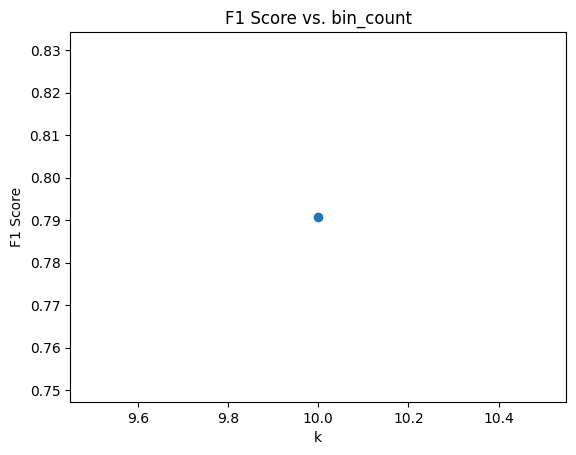

In [26]:
plt.plot(f1_by_k_bins["bin_count"], f1_by_k_bins["f1"], marker='o') # Use plt.plot() for line plots
plt.title("F1 Score vs. bin_count")
plt.xlabel("k")
plt.ylabel("F1 Score")
plt.show()

In [27]:
# Print average scores
print()
print("Average Scores for Best Run (optimal k and bin_count):")
print(f"n_neighbors = {optimal_k}")
print(f"Precision: {optimal_run['precision']:.4f} (+/- {optimal_run['std_precision']:.4f})")
print(f"Recall: {optimal_run['recall']:.4f} (+/- {optimal_run['std_recall']:.4f})")
print(f"Accuracy: {optimal_run['accuracy']:.4f} (+/- {optimal_run['std_accuracy']:.4f})")
print(f"F1 Score: {optimal_run['f1']:.4f} (+/- {optimal_run['std_f1']:.4f})")


Average Scores for Best Run (optimal k and bin_count):
n_neighbors = 1
Precision: 0.7972 (+/- 0.0346)
Recall: 0.7910 (+/- 0.0343)
Accuracy: 0.7910 (+/- 0.0343)
F1 Score: 0.7907 (+/- 0.0334)


In [28]:
model = best_model.fit(transformed_dataset[transformed_feature_names], transformed_dataset[y[0]].map(class_map))
y_pred = pd.Series(model.predict(transformed_dataset[transformed_feature_names]))

In [29]:
transformed_feature_names

array(['categorical__gender_female', 'categorical__gender_male',
       'categorical__embarked_C', 'categorical__embarked_Q',
       'categorical__embarked_S', 'categorical__class_1st',
       'categorical__class_2nd', 'categorical__class_3rd',
       'categorical__country_Argentina', 'categorical__country_Bosnia',
       'categorical__country_Bulgaria', 'categorical__country_Canada',
       'categorical__country_Channel Islands',
       'categorical__country_Croatia (Modern)',
       'categorical__country_Denmark', 'categorical__country_England',
       'categorical__country_Finland', 'categorical__country_France',
       'categorical__country_Hungary', 'categorical__country_India',
       'categorical__country_Ireland', 'categorical__country_Italy',
       'categorical__country_Lebanon', 'categorical__country_Norway',
       'categorical__country_Scotland', 'categorical__country_Siam',
       'categorical__country_South Africa', 'categorical__country_Sweden',
       'categorical__cou

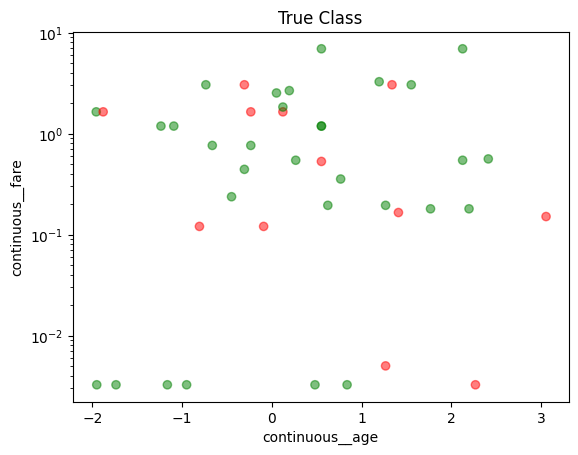

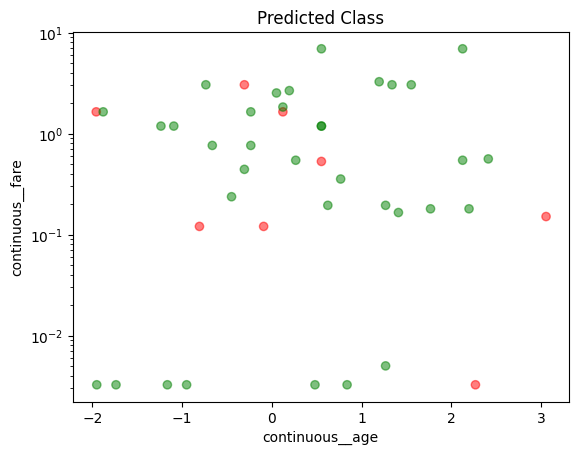

In [30]:
transformed_quant_names = ["continuous__" + quantitative_vars[i] for i in range(len(quantitative_vars))]
plot_types_colors = [("True Class", transformed_dataset[y[0]].map(colormap)),
                     ("Predicted Class", y_pred.map(colormap))]

if len(quantitative_vars) > 1:
  for plot_type, color in plot_types_colors:
      plt.scatter(transformed_dataset[transformed_quant_names[0]],\
                  transformed_dataset[transformed_quant_names[1]],\
                  c=color,\
                  alpha=0.5)

      # Add labels and title
      plt.title(plot_type)
      plt.xlabel(transformed_quant_names[0])
      plt.ylabel(transformed_quant_names[1])
      plt.yscale('log')
      plt.show()

# Compare Models

In [31]:
for model_name, scores in avg_scores.items():
      if model_name != "custom":
          print(f"{model_name}:")
          print(f"Precision: {scores['precision']:.4f} (+/- {scores['std_precision']:.4f})")
          print(f"Recall: {scores['recall']:.4f} (+/- {scores['std_recall']:.4f})")
          print(f"Accuracy: {scores['accuracy']:.4f} (+/- {scores['std_accuracy']:.4f})")
          print(f"F1 Score: {scores['f1']:.4f} (+/- {scores['std_f1']:.4f})")
          print()
      else:
          print(f"{model_name}:")
          print(f"Optimal n_neighbors = {optimal_k}")
          print(f"Precision: {optimal_run['precision']:.4f} (+/- {optimal_run['std_precision']:.4f})")
          print(f"Recall: {optimal_run['recall']:.4f} (+/- {optimal_run['std_recall']:.4f})")
          print(f"Accuracy: {optimal_run['accuracy']:.4f} (+/- {optimal_run['std_accuracy']:.4f})")
          print(f"F1 Score: {optimal_run['f1']:.4f} (+/- {optimal_run['std_f1']:.4f})")
          print()

decision tree classifier:
Precision: 0.6996 (+/- 0.0335)
Recall: 0.6384 (+/- 0.0655)
Accuracy: 0.7462 (+/- 0.0432)
F1 Score: 0.6661 (+/- 0.0437)

knn classifier:
Precision: 0.6499 (+/- 0.0520)
Recall: 0.6208 (+/- 0.1074)
Accuracy: 0.7112 (+/- 0.0671)
F1 Score: 0.6305 (+/- 0.0643)

gaussian naive bayes classifier:
Precision: 0.4388 (+/- 0.0371)
Recall: 0.9664 (+/- 0.0433)
Accuracy: 0.4924 (+/- 0.0415)
F1 Score: 0.6015 (+/- 0.0287)

svm classifier:
Precision: 0.8165 (+/- 0.0975)
Recall: 0.6039 (+/- 0.1162)
Accuracy: 0.7857 (+/- 0.0524)
F1 Score: 0.6866 (+/- 0.0871)

mlp classifier:
Precision: 0.7936 (+/- 0.0861)
Recall: 0.6688 (+/- 0.0882)
Accuracy: 0.7911 (+/- 0.0433)
F1 Score: 0.7176 (+/- 0.0448)

rf classifier:
Precision: 0.7322 (+/- 0.0430)
Recall: 0.7061 (+/- 0.0739)
Accuracy: 0.7761 (+/- 0.0317)
F1 Score: 0.7143 (+/- 0.0258)

custom:
Optimal n_neighbors = 1
Precision: 0.7972 (+/- 0.0346)
Recall: 0.7910 (+/- 0.0343)
Accuracy: 0.7910 (+/- 0.0343)
F1 Score: 0.7907 (+/- 0.0334)



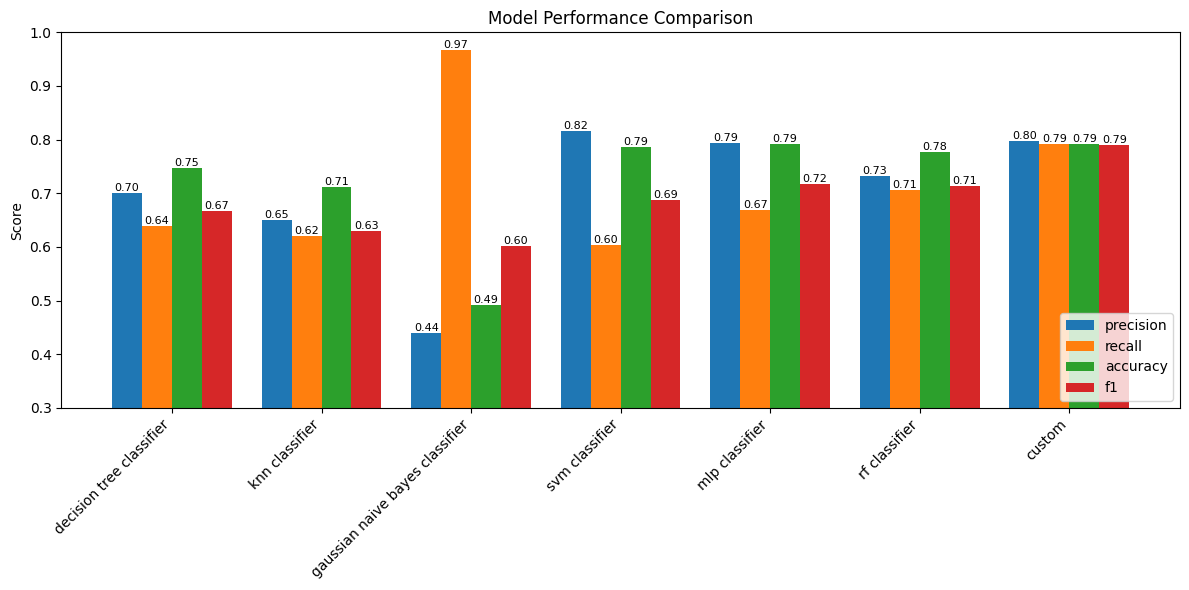

In [32]:
# Prepare data for plotting
models = list(avg_scores.keys())
metrics = ['precision', 'recall', 'accuracy', 'f1']
x = np.arange(len(models))
width = 0.2
fig, ax = plt.subplots(figsize=(12, 6))

# Plot bars for each metric
for i, metric in enumerate(metrics):
    values = []
    for model in models:
        if model == 'custom':
            values.append(optimal_run[metric])
        else:
            values.append(avg_scores[model][metric])
    ax.bar(x + i*width, values, width, label=metric)

# Customize the plot
ax.set_ylabel('Score')
ax.set_title('Model Performance Comparison')
ax.set_xticks(x + width * 1.5)
ax.set_xticklabels(models, rotation=45, ha='right')
ax.legend(loc='lower right')
ax.set_ylim(0.3, 1)

# Add value labels on top of each bar
for i, metric in enumerate(metrics):
    values = []
    for model in models:
        if model == 'custom':
            values.append(optimal_run[metric])
        else:
            values.append(avg_scores[model][metric])
    for j, v in enumerate(values):
        ax.text(j + i*width, v, f'{v:.2f}', ha='center', va='bottom', rotation=0, fontsize=8)

plt.tight_layout()
plt.show()